### Try COLAB

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    !pip3 install torch matplotlib torchmetrics scikit-image segmentation-models-pytorch

# Import

In [2]:
import torch
from torch import nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence # for padding data

import pandas as pd # for making csv file

from sklearn.metrics import accuracy_score, f1_score

import wandb

import seaborn as sns
import matplotlib.pyplot as plt

import random


### CUDA

In [3]:
# GPU Support?
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device('cuda')
else:
    print("Using the CPU")
    device = torch.device('cpu')

Using the GPU


# Generate Dataset

In [4]:
# Generate a dataset of sequences containing characters 'a', 'b', and 'c' in order
def gen_data(N=3000, min_len=3, max_len=20) -> list:
    """Generates a dataset of sequences containing characters 'a', 'b', and 'c' in order.
    Parameters: N: int, number of sequences to generate
                min_len: int, minimum length of a sequence
                max_len: int, maximum length of a sequence
    Returns: list of strings, each string is a sequence of characters 'a', 'b', and 'c' in order"""
    dataset = []
    max_member = max_len // 3 # three times this number is less than max_len
    min_member = min_len // 3 # three times this number is less than min_len
    if min_len < 3:
        min_len = 3
        print("Minimum length must be at least 3. Setting min_len to 3.")
    if max_len > 1000:
        max_len = 1000
        print("Maximum length must be at most 1000. Setting max_len to 1000.")

    for n in range(N):
        if n % 4 == 0: # 25% of the time add actual member of formal language family
            length = random.randint(min_member, max_member)
            sequence = 'a' * length + 'b' * length + 'c' * length
            dataset.append(sequence)
        else:
            length = random.randint(min_len-3, max_len-3)  # Random sequence length between 3 and (20-3 = 17). 3 is the smallest possible length for a sequence to be in the language
            counts = [1, 1, 1] # Initialize counts for 'a', 'b', and 'c'. Will have at least one of each letter.

            # Distribute the length among a, b, and c
            for i in range(length):
                counts[random.randint(0, 2)] += 1

            # Ensure alphabetical order and create the sequence
            sequence = 'a' * counts[0] + 'b' * counts[1] + 'c' * counts[2]
            dataset.append(sequence)
    return dataset

### Functions for labels and encoding

In [5]:
# Get labels
def get_labels(data, vebrose=False):
    y = torch.zeros(len(data))
    for i, sequence in enumerate(data):
        if sequence == 'a'*(len(sequence)//3) + 'b'*(len(sequence)//3) + 'c'*(len(sequence)//3):
            y[i] = 1
    if vebrose:
        print(f"Number of sequences in the language: {y.sum()}")
        print(f"Number of sequences not in the language: {len(y) - y.sum()}")
    return y

In [6]:
# Create a one-hot encoding of the sequences and a labels tensor
def one_hot_encode(sequence):
    encoded = torch.zeros(len(sequence), 3)
    for i, char in enumerate(sequence):
        encoded[i, 'abc'.index(char)] = 1
    return encoded

## One-Hot Encoding

In [7]:
def get_dataset(N, min_len=3, max_len=20, split=False):
    """
    Generates a dataset of sequences containing characters 'a', 'b', and 'c' in order.
    One-hot encodes, pads, and creates labels for the dataset.
    Parameters: N: int, number of sequences to generate
                min_len: int, minimum length of a sequence
                max_len: int, maximum length of a sequence
                split: bool, whether to split the dataset into train and test sets
    Returrns: TensorDataset, list of sequencese if split=False
                Tuple(TensorDataset, TensorDataset), list of sequences if split=True
    """
    sequences = gen_data(N, min_len, max_len)
    length_tensor = torch.tensor([len(s) for s in sequences])
    encoded_sequences = [one_hot_encode(sequence) for sequence in sequences]
    padded_sequences = pad_sequence(encoded_sequences, batch_first=True)
    y = get_labels(sequences, vebrose=True) # change verbose to False to suppress output
    if split: # split into train and test sets
        train_size = int(0.8 * N) # 80/20 train/test split
        train_data = padded_sequences[:train_size]
        test_data = padded_sequences[train_size:]
        train_lengths = length_tensor[:train_size]
        test_lengths = length_tensor[train_size:]
        train_y = y[:train_size]
        test_y = y[train_size:]
        train_dataset = TensorDataset(train_data, train_y, train_lengths)
        test_dataset = TensorDataset(test_data, test_y, test_lengths)
        return train_dataset, test_dataset, sequences
    dataset = TensorDataset(padded_sequences, y, length_tensor)
    return dataset, sequences

In [8]:
train_dataset, test_dataset, sequences = get_dataset(3000, 3, 20, split=True)

Number of sequences in the language: 932.0
Number of sequences not in the language: 2068.0


In [9]:
# Make data into loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# RNN Model

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_length, seq_length, input_size/vocab_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input, lengths):
        # Gets a padded sequence as input
        packed_input = pack_padded_sequence(input, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.rnn(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = out[range(len(out)), lengths-1, :]
        # The shape changes from [batch_size, max_seq_length, hidden_size] to [batch_size, hidden_size]
        # by selecting the output if last valid timestep for each sequence in the batch
        # which reduces the second dimension (sequence length) by selecting specific indices for each sequence in the batch.
        out = self.fc(out)
        return out 

# LSTM Model

In [11]:
# LSTM Model Definition
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input, lengths):
        packed_input = pack_padded_sequence(input, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (hn, cn) = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = out[range(len(out)), lengths-1, :]
        out = self.fc(out)
        return out

# Artifact

In [12]:
# # Make dataset with labels to csv
# df = pd.DataFrame(sequences)
# df['label'] = get_labels(sequences)
# df.to_csv('formal_language.csv', index=False)

# # Instantiate a WandB run
# wandb.login()
# run = wandb.init(project="formal_language_rnn_lstm")

# # Create an artifact for data
# artifact = wandb.Artifact("formal_language_data", type="dataset") 
# artifact.add_file("formal_language.csv") 
# run.log_artifact(artifact)

In [13]:
def report_evaluation(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label, lengths in loader:
            data, label, lengths = data.to(device), label.to(device), lengths.to('cpu')

            # Get the model's predictions
            output = model(data, lengths)
            pred = torch.round(torch.sigmoid(output)) # Sigmoid to get probabilities, round to get binary predictions

            y_true.extend(label.tolist())
            y_pred.extend(pred.tolist())

    # Check if all predictions are 0 or 1
    y_pred_sum = [sum(pred) for pred in y_pred]
    if y_pred_sum == 0:
        print("All predictions are 0")
    if y_pred_sum == len(y_pred):
        print("All predictions are 1")

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    return accuracy, f1

# Sweeping

In [14]:
# Sweep config
sweep_config = {
    "method": "random",
    "metric": {"name": "loss", "goal": "minimize"},
    "parameters": {
        "model": { "values": ["RNN", "LSTM"] },
        "epochs": {"values": [10, 20, 30] },    
        "optimizer": { "values": ["SGD", "Adam"] },
        "hidden_size": {
            "values": [10, 20, 50]
        },
        "num_layers": {
            "values": [1, 2]
        },
        "learning_rate": {
            "values": [0.001, 0.005, 0.01]
        }
    }
}

In [15]:
def train(config=None):
    with wandb.init(project="formal_language_rnn_lstm", config=config):
        config = wandb.config

        # Get hyperparameters
        hidden_size = config.hidden_size
        num_layers = config.num_layers
        learning_rate = config.learning_rate
        num_epochs = config.epochs

        # Input size and number of classes
        num_classes = 1 # binary classification
        input_size = 3 # 'a' 'b' 'c'

        # Set criterion
        criterion = nn.BCEWithLogitsLoss()

        # Get model
        if config.model == "RNN":
            model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
        else:
            model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
        
        # Get optimizer
        if config.optimizer == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        else:
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        wandb.watch(model, criterion, log="all")

        # Make validation set from global var train_dataset
        train_size = int(0.9*len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
        # Make loaders
        val_train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=len(val_subset), shuffle=False)


        # Training loop
        for epoch in range(num_epochs):
            for data, labels, lengths in val_train_loader:
                data, labels, lengths = data.to(device), labels.to(device), lengths.to('cpu')

                # Forward pass
                outputs = model(data, lengths)
                loss = criterion(outputs.squeeze(), labels.float())

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            wandb.log({"epoch": epoch+1, "loss": loss.item()})

            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
        _,f1 = report_evaluation(model, val_loader)
        wandb.log({"f1_eval": f1})
        
        print("Finished training")

In [16]:
# Initialize sweep_id
# sweep_id = wandb.sweep(sweep_config, project="formal_language_rnn_lstm")

In [17]:
# Run the sweep
# wandb.agent(sweep_id, function=train, count=15)

# Evaluation

## Train with selected params

In [18]:
# RNN Params
input_size =  3 # 'a' 'b' 'c'
num_classes = 1 # binary classification
hidden_size = 50 # hyperparameter; chosen from sweep
num_layers = 2 # hyperparameter; chosen from sweep


criterion = nn.BCEWithLogitsLoss() # "hyperparameter" chosen from sweep
learning_rate = 0.001 # hyperparameter; chosen from sweep

# Train RNN
rnn = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate) # hyperparameter; chosen from sweep

# Training loop RNN
num_epochs = 30 # hyperparameter; chosen from sweep
for epoch in range(num_epochs):
    for data, labels, lengths in train_loader:
        data, labels, lengths = data.to(device), labels.to(device), lengths.to('cpu')
        
        # Forward pass
        outputs = rnn(data, lengths)
        loss = criterion(outputs.squeeze(), labels.float()) # BCEWithLogitsLoss expects 1D input, output from RNN is 2D
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Finished Training")

Epoch [1/30], Loss: 0.4844
Epoch [2/30], Loss: 0.6357
Epoch [3/30], Loss: 0.3865
Epoch [4/30], Loss: 0.2547
Epoch [5/30], Loss: 0.1916
Epoch [6/30], Loss: 0.2049
Epoch [7/30], Loss: 0.1517
Epoch [8/30], Loss: 0.1682
Epoch [9/30], Loss: 0.2202
Epoch [10/30], Loss: 0.1259
Epoch [11/30], Loss: 0.1319
Epoch [12/30], Loss: 0.1504
Epoch [13/30], Loss: 0.0930
Epoch [14/30], Loss: 0.1486
Epoch [15/30], Loss: 0.1435
Epoch [16/30], Loss: 0.1942
Epoch [17/30], Loss: 0.1327
Epoch [18/30], Loss: 0.1190
Epoch [19/30], Loss: 0.0828
Epoch [20/30], Loss: 0.0833
Epoch [21/30], Loss: 0.1100
Epoch [22/30], Loss: 0.0850
Epoch [23/30], Loss: 0.0964
Epoch [24/30], Loss: 0.0730
Epoch [25/30], Loss: 0.1380
Epoch [26/30], Loss: 0.1590
Epoch [27/30], Loss: 0.0157
Epoch [28/30], Loss: 0.1104
Epoch [29/30], Loss: 0.0686
Epoch [30/30], Loss: 0.0152
Finished Training


In [45]:
# LSTM Params
input_size =  3 # 'a' 'b' 'c'
num_classes = 1 # binary classification
hidden_size = 20 # hyperparameter; chosen from sweep
num_layers = 1 # hyperparameter; chosen from sweep


criterion = nn.BCEWithLogitsLoss() # "hyperparameter" chosen from sweep
learning_rate = 0.01 # hyperparameter; chosen from sweep

# Train LSTM
lstm = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate) # hyperparameter; chosen from sweep

# Training loop LSTM
num_epochs = 20 # hyperparameter; chosen from sweep

for epoch in range(num_epochs):
    for data, labels, lengths in train_loader:
        data, labels, lengths = data.to(device), labels.to(device), lengths.to('cpu')

        # Forward pass
        outputs = lstm(data, lengths)
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Finished training")

Epoch [1/20], Loss: 0.5808
Epoch [2/20], Loss: 0.6512
Epoch [3/20], Loss: 0.6093
Epoch [4/20], Loss: 0.5297
Epoch [5/20], Loss: 0.4628
Epoch [6/20], Loss: 0.6020
Epoch [7/20], Loss: 0.5357
Epoch [8/20], Loss: 0.2843
Epoch [9/20], Loss: 0.3040
Epoch [10/20], Loss: 0.2729
Epoch [11/20], Loss: 0.3205
Epoch [12/20], Loss: 0.3194
Epoch [13/20], Loss: 0.3770
Epoch [14/20], Loss: 0.3057
Epoch [15/20], Loss: 0.2185
Epoch [16/20], Loss: 0.1961
Epoch [17/20], Loss: 0.1783
Epoch [18/20], Loss: 0.1539
Epoch [19/20], Loss: 0.1625
Epoch [20/20], Loss: 0.1321
Finished training


## Report F1 Score (and accuracy)

In [46]:
rnn_accuracy, rnn_f1 = report_evaluation(rnn, test_loader)
lstm_accuracy, lstm_f1 = report_evaluation(lstm, test_loader)


print(f'RNN Test Accuracy: {rnn_accuracy*100:.2f}%')
print(f'RNN F1 Score: {rnn_f1:.2f}')
print(f'LSTM Test Accuracy: {lstm_accuracy*100:.2f}%')
print(f'LSTM F1 Score: {lstm_f1:.2f}')

RNN Test Accuracy: 97.33%
RNN F1 Score: 0.96
LSTM Test Accuracy: 93.17%
LSTM F1 Score: 0.90


# Generalization and Plot

In [47]:
# Generate new test data of len 21 to 30 to see how well the models generalize
longSeq_dataset, longSeq_sequences = get_dataset(1000, min_len=21, max_len=100, split=False)
longSeq_loader = DataLoader(longSeq_dataset, batch_size=len(longSeq_dataset), shuffle=False)

Number of sequences in the language: 253.0
Number of sequences not in the language: 747.0


In [41]:
def length_to_scores(model, loader):
    """
    Get the F1 score of a model for each sequence length in the test set
    """
    model.eval()
    length_to_true_pred = {}
    with torch.no_grad():
        for data, label, lengths in loader:
            data, label, lengths = data.to(device), label.to(device), lengths.to('cpu')

            # Get the model's predictions
            output = model(data, lengths)
            pred = torch.round(torch.sigmoid(output)) # Sigmoid to get probabilities, round to get binary predictions
            
            for i, length in enumerate(lengths):
                if length.item() not in length_to_true_pred:
                    length_to_true_pred[length.item()] = {'true': [], 'pred': []}

                length_to_true_pred[length.item()]['true'].append(label[i].item())
                length_to_true_pred[length.item()]['pred'].append(pred[i].item())

    # sort list
    length_to_true_pred = dict(sorted(length_to_true_pred.items()))
        
    # check if all predictions are the same for each length
    for length in length_to_true_pred:
        if length_to_true_pred[length]['pred'] == ([0*len(length_to_true_pred[length]['pred'])] or [1*len(length_to_true_pred[length]['pred'])]):
            print(f"All predictions are {length_to_true_pred[length]['pred'][0]} for sequences of length {length}")

    length_to_f1 = {}
    length_to_accuracy = {}
    for length, values in length_to_true_pred.items():
        f1 = f1_score(values['true'], values['pred'], zero_division=1) # zero_division=1 to avoid division by 0
        accuracy = accuracy_score(values['true'], values['pred'])
        length_to_f1[length] = f1
        length_to_accuracy[length] = accuracy


    return length_to_f1 , length_to_accuracy


In [48]:
rnn_accuracy, rnn_f1 = report_evaluation(rnn, longSeq_loader)
lstm_accuracy, lstm_f1 = report_evaluation(lstm, longSeq_loader)


print(f'RNN Test Accuracy: {rnn_accuracy*100:.2f}%')
print(f'RNN F1 Score: {rnn_f1:.2f}')
print(f'LSTM Test Accuracy: {lstm_accuracy*100:.2f}%')
print(f'LSTM F1 Score: {lstm_f1:.2f}')

RNN Test Accuracy: 74.50%
RNN F1 Score: 1.00
LSTM Test Accuracy: 71.00%
LSTM F1 Score: 1.00


In [49]:
# Plot F1 scores for each sequence length for RNN and LSTM bar plot side by side
rnn_f1, rnn_accuracy = length_to_scores(rnn, longSeq_loader)
lstm_f1, lstm_accuracy= length_to_scores(lstm, longSeq_loader)

In [55]:
print(lstm_accuracy)

{21: 0.36, 22: 1.0, 23: 1.0, 24: 0.4444444444444444, 25: 0.8333333333333334, 26: 1.0, 27: 0.6, 28: 1.0, 29: 1.0, 30: 0.6666666666666666, 31: 0.9090909090909091, 32: 1.0, 33: 0.47619047619047616, 34: 1.0, 35: 1.0, 36: 0.5714285714285714, 37: 1.0, 38: 1.0, 39: 0.3333333333333333, 40: 0.8571428571428571, 41: 0.9090909090909091, 42: 0.6, 43: 1.0, 44: 1.0, 45: 0.47058823529411764, 46: 0.625, 47: 1.0, 48: 0.7083333333333334, 49: 1.0, 50: 0.8571428571428571, 51: 0.4444444444444444, 52: 1.0, 53: 1.0, 54: 0.5294117647058824, 55: 0.7777777777777778, 56: 0.9285714285714286, 57: 0.42857142857142855, 58: 1.0, 59: 0.875, 60: 0.5357142857142857, 61: 1.0, 62: 1.0, 63: 0.5, 64: 1.0, 65: 0.9333333333333333, 66: 0.4, 67: 0.9, 68: 1.0, 69: 0.23076923076923078, 70: 0.8571428571428571, 71: 1.0, 72: 0.42105263157894735, 73: 1.0, 74: 0.875, 75: 0.3157894736842105, 76: 1.0, 77: 1.0, 78: 0.42105263157894735, 79: 0.8947368421052632, 80: 0.9090909090909091, 81: 0.42857142857142855, 82: 1.0, 83: 0.8333333333333334

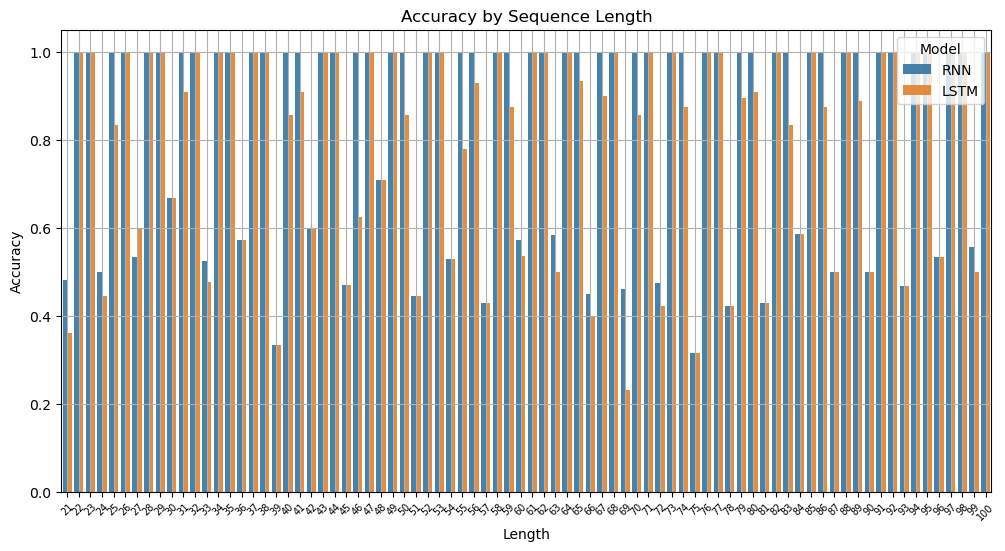

In [67]:

# Plot Accuracy scores side by side using seaborn in w/ barplot same plot
rnn_df = pd.DataFrame(list(rnn_accuracy.items()), columns=['Length', 'Accuracy'])
rnn_df['Model'] = 'RNN'
lstm_df = pd.DataFrame(list(lstm_accuracy.items()), columns=['Length', 'Accuracy'])
lstm_df['Model'] = 'LSTM'
df = pd.concat([rnn_df, lstm_df])

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Length', y='Accuracy', hue='Model', alpha=0.9)
plt.grid()
# fix x-axis labels
plt.xticks(rotation=45, size=7)
plt.title('Accuracy by Sequence Length')
plt.savefig('accuracy_by_length.png')
plt.show()
